# Imports

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable
from PIL import Image
from ffnet import MLP, FourierFeatureEmbedding
import os

# Sample Image

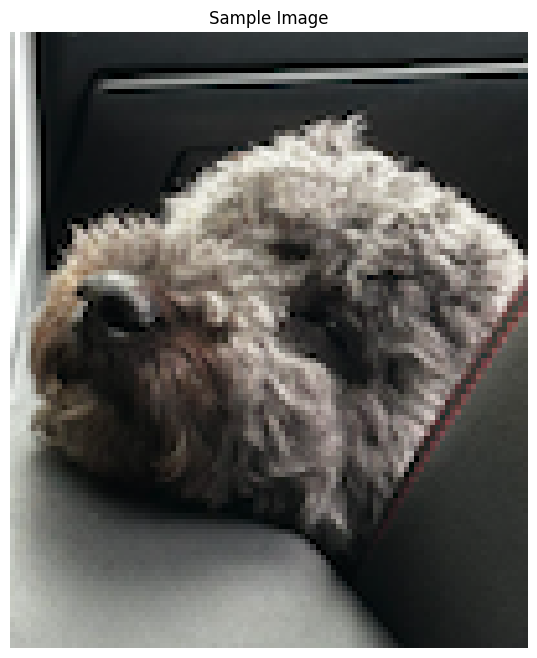

In [ ]:
'''Visualizing sample image'''

im_path = os.path.join("..", "images", "dog_original.png")
samp_im = Image.open(im_path)

plt.figure(figsize=(16, 8))
plt.imshow(samp_im,cmap='gray');
plt.title('Sample Image')
plt.axis('off')
plt.show()

# Training Dataset Initialization

In [ ]:
'''Turning the sample image into a pointgrid'''

im_array = np.array(samp_im) / 255
height, width, channels = im_array.shape

init_x_grid, init_y_grid = np.meshgrid(np.arange(height),
                             np.arange(width),
                             indexing="ij")

x_grid = init_x_grid / (height - 1)
y_grid = init_y_grid / (width - 1)

train_output = im_array.reshape(width * height, channels)
train_input = np.stack([y_grid.ravel(),
                        x_grid.ravel()],
                        axis=-1)

'''Initializing RBF embedding'''

num_rand_features = 10
length_scale = 0.5

rbf_features = FourierFeatureEmbedding(input_dim=2, num_features=num_rand_features,
                                        kernel='RBF', length_scale=length_scale)

rbf_train_input = rbf_features.embed(train_input)

In [ ]:
'''Creating datasets and trainloaders'''

base_input_tens = torch.tensor(train_input,
                               dtype=torch.float32)
rbf_input_tens = torch.tensor(rbf_train_input,
                              dtype=torch.float32)
output_tens = torch.tensor(train_output,
                           dtype=torch.float32)

base_data_tens = TensorDataset(base_input_tens,
                               output_tens)
rbf_data_tens = TensorDataset(rbf_input_tens,
                              output_tens)

base_loader_tens = DataLoader(base_data_tens, batch_size=100, shuffle=True)
rbf_loader_tens = DataLoader(rbf_data_tens, batch_size=100, shuffle=True)

input_tensors = [base_input_tens, rbf_input_tens]
train_loaders = [base_loader_tens, rbf_loader_tens]

# Network Initialization

In [ ]:
'''Global MLP architecture'''

hidden_layers = 4
hidden_width = 128

'''Initializing embedding-free and RBF-embedding networks'''

base_mlp = MLP(input_dim=2, output_dim=4,
               hidden_layers=hidden_layers,
               hidden_width=hidden_width)

rbf_mlp = MLP(input_dim=2*num_rand_features,
              output_dim=4,
              hidden_layers=hidden_layers,
              hidden_width=hidden_width)

mlps = [base_mlp, rbf_mlp]

# Network Training

In [ ]:
'''Training networks'''

num_iters = 250

num_nets = len(mlps)
loss = nn.MSELoss()

for step in range(num_iters):
  for idx in range(num_nets):
    mlps[idx].train(train_loaders[idx], 1)

# Network Comparison

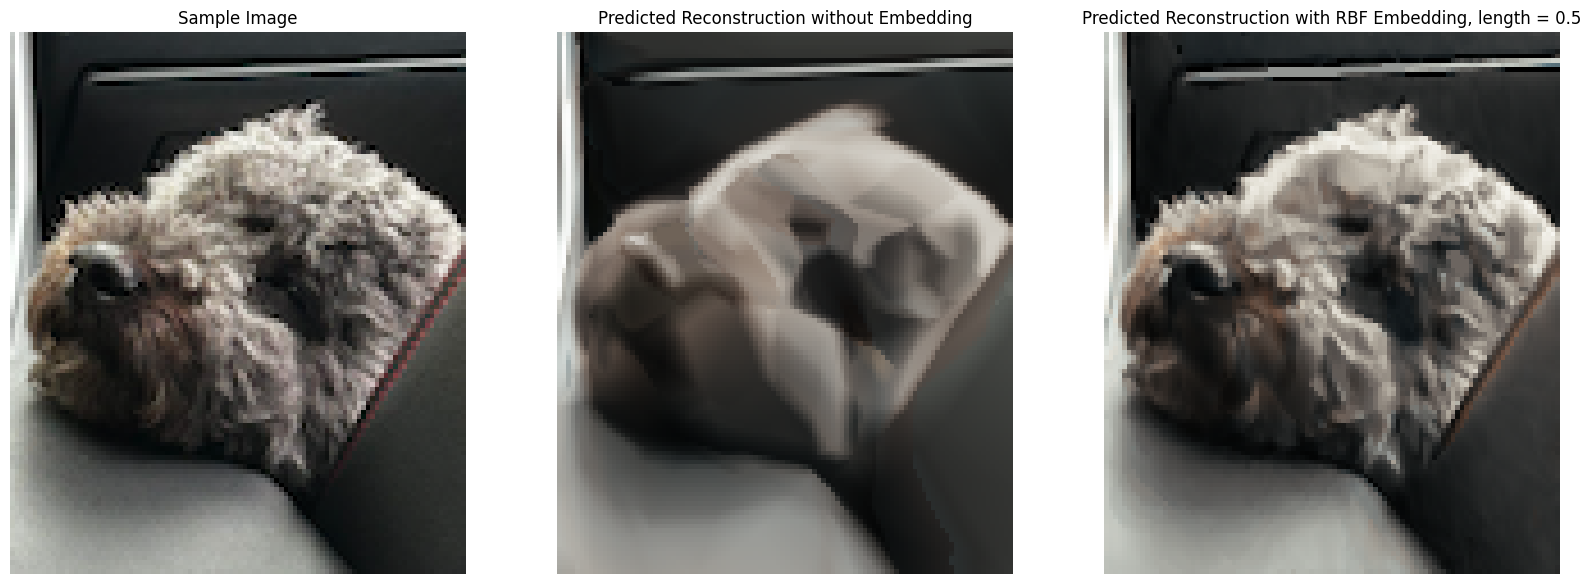

In [ ]:
'''Visualizing network predictions'''

pred_outputs = [mlps[idx](input_tensors[idx])
                .detach().numpy().reshape(height, width, channels)
                for idx in range(num_nets)]

figs, axs = plt.subplots(1, 3, figsize=(20, 24))

axs[0].axis('off')
axs[0].imshow(samp_im,cmap='gray')

for idx in range(1, 3):
  axs[idx].axis('off')
  axs[idx].imshow(pred_outputs[idx - 1],
                      cmap='gray')

axs[0].set_title('Sample Image')
axs[1].set_title('Predicted Reconstruction without Embedding')
axs[2].set_title('Predicted Reconstruction with RBF Embedding, length = '
                  + str(length_scale))
plt.show()

# Image Upscaling

In [ ]:
'''Upscaling an image using the trained network'''

width_scale, height_scale = 3, 3
new_width = int(width_scale * width)
new_height = int(height_scale * height)

init_new_x_grid, init_new_y_grid = np.meshgrid(
                             np.arange(new_height),
                             np.arange(new_width),
                             indexing="ij")

new_x_grid =  init_new_x_grid / (new_height - 1)
new_y_grid =  init_new_y_grid / (new_width - 1)

new_input = np.stack([new_y_grid.ravel(),
                      new_x_grid.ravel()],
                      axis=-1)

embed_input = torch.tensor(rbf_features.embed(new_input),
                           dtype=torch.float32)
pred_upscale = rbf_mlp(embed_input).detach().numpy().reshape(new_height,
                                                             new_width,
                                                             channels)

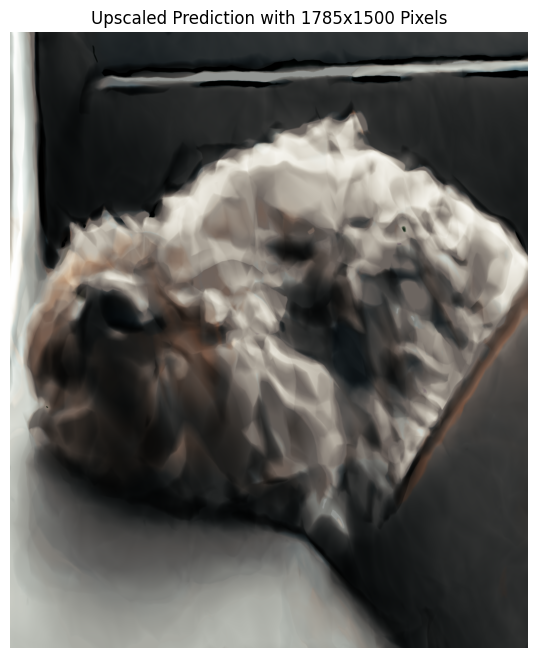

In [ ]:
plt.figure(figsize=(16, 8))
plt.imshow(pred_upscale,cmap='gray');
plt.title('Upscaled Prediction with ' + str(new_height) + 'x' +
                                        str(new_width) + ' Pixels')
plt.axis('off')
plt.show()